# Invariant Representations Tutorial


This is part of an Invariant Representations tutorial series. There's a short intro here to the theory behind what's going on, but for more in depth coverage see [this unimplemented second part](sorry dead link right now). This tutorial requires basic variational auto-encoder knowledge, and some information theory knowledge, but otherwise should hopefully be pretty accessible.

If you're not familiar with VAE, there's a great tutorial from Lilian Weng [here](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html).
I should find a IT for ML tutorial, but I haven't yet, so if you know of a good one please link me!

PLEASE leave comments/advice/requests. I'm new at this, so this is probably sub-optimal, whatever its current state. I'm also not a regular .ipynb user, so even minor things can be PR'd in happily.

This tutorial is done in Keras/TF.


## Theory summary

**Three sentence setup from VAE:** Regular auto-encoders learn functions $q(z|x)$ and $p(x|z)$, which respectively encode and decode our data $x$ to a lower-dimensional variable $z$. If the auto-encoder does well, then $p(x|z = q(z|x))$ is close to $x$. VAE builds on this, letting $q$ be a probabilistic mapping, so that $q(z|x)$ is a distribution, usually a Gaussian.

**The invariant auto-encoder objective:** We want to learn $q$ and $p$ in the same setup that
1. accurately describes $x$ (just like regular AEs)
2. has a $z$ that is invariant to outside factor $c$ (the invariance condition)

The first part can be described using maximum likelihood from e.g. [Kingma and Welling 2013](https://arxiv.org/abs/1312.6114):

$$ \max \mathbb{E}_{q(z|x)p(x)}[ p(x|z) ] $$

We can write down a Markov chain that describes this setup: $ c \rightarrow x \rightarrow z $. We want to enforce the constraint $z\perp c$, i.e. $z$ independent of $c$, i.e. that $p(z|c) = p(z)$. Basically: *Make sure $z$ doesn't change if you change $c$*.

Okay, so what if we can't do that? $z \perp c$ is a really harsh constraint.

One idea: relax it to minimal mutual information, $\min I(z,c)$. If $I(z,c)$ is close to $0$, then we're good.

How do we minimize $I(z,c)$? This, it turns out, is also hard (are you sensing a theme) for arbitrary encodings $z$. Doing some* math we end up at this bound:

$$I(z, c) \leq
\underbrace{- \mathbb{E}_{x,c,z\sim q}[ \log p(x|z,c)]}_{\text{Reconstruction}}
+ \underbrace{\mathbb{E}_{x}[~KL[~q(z|x)~\|~q(z)~]~  ]}_{\text{Compression}}
- \underbrace{\vphantom{\mathbb{E}_{x,q}[]}H(x|c)}_{\text{Const}}$$
\*"some" meaning section 2 of [our paper](https://arxiv.org/abs/1805.09458).

This has two parts we can optimize, $p(x|z,c)$ and $q(z|x)$. These look like an encoder and decoder pair from the auto-encoders introduced at the start, except our decoder is conditional. We also have an additional KL term. Otherwise it's the same as an auto-encoder.

<a id="theory-tldr"></a>
**TL;DR:** Use a conditional decoder and an additional KL term to make your auto-encoder invariant to whatever you conditioned on.

The "TODO List":
* Make a generic encoder, $q(z|x)$.
* Make a conditional decoder, $p(x|z,c)$.
* Implement that KL loss (or an approximation thereof): $KL[~q(z|x)~\|~q(z)~]$

That's what we're going to do here, using neural networks for $p$ and $q$.

### Additional Motivations/Reference Notes

In classical CV/ML, we might have designed these analytically for things like rotation, translation, scaling, etc.; these transformations themselves have analytic descriptions, and we can view the removal their effects as [quotienting out a group operation](https://arxiv.org/abs/1602.07576).

For more general factors $c$, this isn't always possible. One example in [algorithmic fairness](https://arxiv.org/abs/1511.00830) requires the removal of sensitive or protected attributes (Race, Religion, Gender, Orientation) from $x$, which is a) probably not a group operation, and b) definitely has no easy analytic description. This also occurs in [instrument bias](https://arxiv.org/abs/1904.05375) for observational studies. Further, for generative models it can be helpful to "modulo out" certain factors, only to add them back in a [controlled manner](https://arxiv.org/abs/1706.00409).

We summarized our theory objective with: "*Make sure $z$ doesn't change if you change $c$*". Here, "*you*" is often "*a mysterious force which we cannot control*", since if we could change $c$ and get new $(x,c)$ pairs, we could perform data augmentation. In fact, we find this regularly occuring things like rotation, translation, etc., and for some effects which aren't groups/semi-groups (occlusions, additive noise). It's simple and it "completes the orbit". In other words: it adds an $x$ to our dataset for each possible value of $c$. Usually on the fly.

## Programming Setup

Okay, so we'll need Keras, Numpy, and MNIST data. I'm going to hide all that, but we're going to get $x$ as a big flat vector and $y$ as a one-hot categorical variable.

In [1]:
import keras
import keras.backend as K
import tensorflow as tf
import numpy as np

IMG_DIM = 28
NUM_LABELS = 10

#data comes as images and 1-dim {0,...,9} categorical variable
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
  
#cast and flatten images, renormalizing to [0,1]
train_x = train_x.astype(np.float32).reshape( (train_x.shape[0], IMG_DIM**2) ) / 255.0
test_x = test_x.astype(np.float32).reshape( (test_x.shape[0], IMG_DIM**2) ) / 255.0

#copypaste
def one_hot(labels):
    num_labels_data = labels.shape[0]
    one_hot_encoding = np.zeros((num_labels_data,NUM_LABELS))
    one_hot_encoding[np.arange(num_labels_data),labels] = 1
    one_hot_encoding = np.reshape(one_hot_encoding, [-1, NUM_LABELS])
    return one_hot_encoding

train_y = one_hot(train_y).astype(np.float32)
test_y = one_hot(test_y).astype(np.float32)

Using TensorFlow backend.


In [2]:
print(train_x.shape)
print(train_y.shape)

(60000, 784)
(60000, 10)


## Building a Conditional VAE architecture 
<a id="arch-construction"></a>

The Conditional VAE is, as its name suggests, a variational auto-encoder with conditional output. This means it should 
1. Take in $x$ and map it to a latent variable $z$ using the encoder
2. Map $z$ to a new $\hat{x}$ using the decoder.
3. Condition (a.k.a. control) the output $\hat{x}$ by another input $c$, representing specific other factors.

In order to do this we'll also set a few constants. We're using ```DIM_Z=5```, but feel free to come back and play around with it later. We're also using "tanh" activations, but you can come back and change this as well (e.g. to "relu").

For some this is pretty basic stuff. Skip to [Loss Construction](#loss-construction) if you can do this on your own.

In [3]:
DIM_Z = 16
DIM_C = NUM_LABELS # just as an example. Sometimes we also have another y
INPUT_SHAPE = IMG_DIM ** 2
ACTIVATION = "tanh"

Then we'll build the encoder, which is a two layer fully-connected feed-forward network with two outputs, $z_{mean}$ and $z_{sigma}$. To avoid domain problems, we'll actually output $\log z_{sigma}$. This means we can use a linear layer instead of having to choose a non-negative activation.

In [4]:
#declare inputs to the encoder, which is just x
input_x = keras.layers.Input( shape = [INPUT_SHAPE], name="x" )

#first hidden layer
enc_hidden_1 = keras.layers.Dense(512, activation=ACTIVATION, name="enc_h1")(input_x)
#second hidden layer
enc_hidden_2 = keras.layers.Dense(512, activation=ACTIVATION, name="enc_h2")(enc_hidden_1)

#first output, z_mean
z_mean = keras.layers.Dense(DIM_Z, activation=ACTIVATION)(enc_hidden_2)
#second hidden output, z_log_sigma_sq.
z_log_sigma_sq = keras.layers.Dense(DIM_Z, activation="linear")(enc_hidden_2)

Creating the latent variable $z$ using a Gaussian layer can be a bit tricky, but luckily is covered in the [Keras documentation](https://keras.io/examples/variational_autoencoder/), which this part follows almost exactly. If you haven't seen the reparameterization trick before, this is to create a Gaussian distributed layer $z$ which can be differentiated w.r.t. its parameters. It was popularized by [Kingma and Welling 2013](https://arxiv.org/abs/1312.6114). 

In [5]:
#stolen straight from the docs
#https://keras.io/examples/variational_autoencoder/
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


z_mean = keras.layers.Dense(DIM_Z, activation="tanh")(enc_hidden_2)
z_log_sigma_sq = keras.layers.Dense(DIM_Z, activation="linear")(enc_hidden_2)

z = keras.layers.Lambda(sampling, output_shape=(DIM_Z,), name='z')([z_mean, z_log_sigma_sq])

Great, that's the Encoder from $x$ to $z$ done. Let's build the conditional decoder. There isn't an established standard way to condition the output, but concatenating $z$ and $c$ before inputting into the decoder is good enough for now.

In [6]:
#declare any additional inputs to our decoder, in this case c
input_c = keras.layers.Input( shape = [DIM_C], name="c")
#this is the concat operation!
z_with_c = keras.layers.concatenate([z,input_c])

#first hidden layer
dec_hidden_1 = keras.layers.Dense(512, activation=ACTIVATION, name="dec_h1")(z_with_c)
#second hidden layer
dec_hidden_2 = keras.layers.Dense(512, activation=ACTIVATION, name="dec_h2")(dec_hidden_1)

#output, should be same domain as x_hat
#could also use sigmoid activation
x_hat = keras.layers.Dense( INPUT_SHAPE, name="x_hat", activation="linear" )(dec_hidden_2)

Loss Construction for Invariance (...and also all that VAE stuff)
----
<a id="loss-construction"></a>

Okay, so we have both the encoder and the conditional decoder now, so the next step is building the loss function. There are three sub-components:

1. Reconstruction (how far is $\hat{x}$ from $x$), usually $\|x - \hat{x}\|_2^2$.
2. "Distance" to the Prior (from the original VAE definition), $KL[q(z|x)| p(z)]$
3. "Distance" to the Empirical Marginal Posterior (from our paper, among others), $KL[q(z|x)| q(z)]$.

The third one we'll have to approximate, so we'll deal with that second. First, the two easy ones, straight from Keras Docs, plus defining some hyper parameters:

In [7]:
params = {
  "beta" : 0.1,
  "lambda" : 1.0,
}

recon_loss = keras.losses.mse(input_x, x_hat)
recon_loss *= INPUT_SHAPE #optional, in the tutorial code though

prior_loss = 1 + z_log_sigma_sq - K.square(z_mean) - K.exp(z_log_sigma_sq)
prior_loss = K.sum(prior_loss, axis=-1)
prior_loss *= -0.5

Now for $KL[ q(z|x) | q(z) ]$. Since we're using the Gaussian $z$ layer, there's an approximation we can make using the pairwise Gaussian KL divergences. **In the original version of the paper there is an erroneous extra term at this part.** The corrected version is implemented below, but before we get into it, we should remember that we actually want to compute $KL[ q(z|x) | q(z) ]$, not this bound, and that this could also be solved using:

* Direct approximation (e.g. use a neural network to approximate posterior marginal $q(z)$ term given $q(z|x)$ parameters and samples $x$).
* Sampling
* Use a different $z$ layer with analytic divergence to its marginal.

The first and second options appear in the literature; see e.g. [Fixing a Broken ELBO (Alemi et al. 2017)](https://arxiv.org/abs/1711.00464) and [Structured Disentangled Representations Esmaeili et al. 2018](https://arxiv.org/abs/1804.02086). The third option appears in our paper [Echo Noise](https://arxiv.org/abs/1904.07199), which we'll demonstrate at the end.

Knowing this, here's one way to do it *for Gaussian $z$ layers* using pairwise KL divergence:

In [8]:

#KL(N_0|N_1) = tr(\sigma_1^{-1} \sigma_0) + 
#  (\mu_1 - \mu_0)\sigma_1^{-1}(\mu_1 - \mu_0) - k +
#  \log( \frac{\det \sigma_1}{\det \sigma_0} )
def all_pairs_gaussian_kl(mu, sigma, add_third_term=False):
    sigma_sq = tf.square(sigma) + 1e-8
    sigma_sq_inv = tf.math.reciprocal(sigma_sq)

    #dot product of all sigma_inv vectors with sigma is the same as a matrix mult of diag
    first_term = tf.matmul(sigma_sq,tf.transpose(sigma_sq_inv))
    
    r = tf.matmul(mu * mu,tf.transpose(sigma_sq_inv))
    r2 = mu * mu * sigma_sq_inv 
    r2 = tf.reduce_sum(r2,1)
 
    #squared distance
    #(mu[i] - mu[j])\sigma_inv(mu[i] - mu[j]) = r[i] - 2*mu[i]*mu[j] + r[j]
    #uses broadcasting
    second_term = 2*tf.matmul(mu, tf.transpose(mu*sigma_sq_inv))
    second_term = r - second_term + tf.transpose(r2)

    # log det A = tr log A
    # log \frac{ det \Sigma_1 }{ det \Sigma_0 } =
    #   \tr\log \Sigma_1 - \tr\log \Sigma_0 
    # for each sample, we have B comparisons to B other samples...
    #   so this cancels out

    if(add_third_term):
        r = tf.reduce_sum(tf.math.log(sigma_sq),1)
        r = tf.reshape(r,[-1,1])
        third_term = r - tf.transpose(r)
    else:
        third_term = 0

    #- tf.reduce_sum(tf.log(1e-8 + tf.square(sigma)))\
    # the dim_z ** 3 term comes fro
    #   -the k in the original expression
    #   -this happening k times in for each sample
    #   -this happening for k samples
    #return 0.5 * ( first_term + second_term + third_term - dim_z )
    return 0.5 * ( first_term + second_term + third_term )

#
# kl_conditional_and_marg
#   \sum_{x'} KL[ q(z|x) \| q(z|x') ] + (B-1) H[q(z|x)]
#

#def kl_conditional_and_marg(args):
def kl_conditional_and_marg(z_mean, z_log_sigma_sq, dim_z):
    z_sigma = tf.exp( 0.5 * z_log_sigma_sq )
    all_pairs_GKL = all_pairs_gaussian_kl(z_mean, z_sigma, True) - 0.5*dim_z
    return tf.reduce_mean(all_pairs_GKL)

So after all that, we can create our third loss term. We'll then add them all up, and create our model!

In [9]:
kl_qzx_qz_loss = kl_conditional_and_marg(z_mean, z_log_sigma_sq, DIM_Z)

#Invariant Conditional Variational Autoencoder (ICVAE).
#I think the name game is meh (what if someone else got there first? or defines a different one later?)
#so maybe it'd be easier to say Moyer et al. 2018? too narcissistic? Conditional VAE with additional compression?
#
# ...the point is, this one can induce invariance. So can the others sometimes, too, in practice.

icvae_loss = K.mean((1 + params["lambda"]) * recon_loss + params["beta"]*prior_loss + params["lambda"]*kl_qzx_qz_loss)

icvae = keras.models.Model(inputs=[input_x,input_c], outputs=x_hat, name="ICVAE")

icvae.add_loss(icvae_loss)

learning_rate = 0.0005
opt = keras.optimizers.Adam(lr=learning_rate)

icvae.compile( optimizer=opt, )


/home/dcmoyer/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output x_hat missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to x_hat.
  'be expecting any data to be passed to {0}.'.format(name))


## Training

Only run this bit once. It takes a bit (but not too long tbh). If this isn't your jupyter server, you should delete the path stuff. I just wanted to save you from repetitive gpu time/coffee breaks.

In [10]:
import os
if not os.path.exists("mnist_icvae.h5"):
    print("training")
    icvae.fit(
        { "x" : train_x, "c" : train_y }, epochs=100
    )
    icvae.save_weights("mnist_icvae.h5")
else:
    print("loading from file")
    icvae.load_weights("mnist_icvae.h5")

loading from file


# Plots and Evaluation

Okay, so now that we've trained it, let's see how well it does.

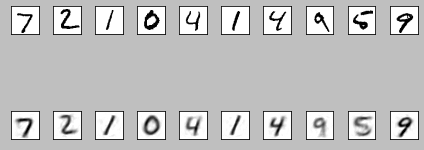

In [13]:
n_plot_samps = 10
test_x_hat = icvae.predict(
 { "x" : test_x[:n_plot_samps], "c" : test_y[:n_plot_samps] }
)

##
## plot first N
##

from src.plot_tools import pics_tools as pic
import matplotlib.pyplot as plt
plt.style.use('grayscale')

fig = pic.plot_image_grid( \
  1-np.concatenate([test_x[:n_plot_samps],test_x_hat], axis=0),
  [IMG_DIM, IMG_DIM], \
  (2,n_plot_samps) \
)
plt.show()

Probably a bit fuzzy right?

One thing we can do immediately though is force our network to use the mean encoding $z$. Currently it's actually sampling, so if you ran the above code block multiple times you'd get different outputs.

Still, fuzzy output is a common complaint of VAE or Auto-encoders in general (in comparison with, e.g., GANs). You can somewhat ameliorate this by more epochs, a bigger latent space, more layers, convolution, etc., but in the end it might be that $\ell_2$ isn't a great image metric (a.k.a. distortion measure). Designing one by hand seems very hard, but 5+ years of GAN research seems to show that adversaries do well (replacing $\log p(x|z,c) \propto \|x - \hat{x} \|$). This is, in effect, training another network $r$ to produce proxy likelihoods $r(x)$ from outputs $p(x|z,c)$. There's nothing stopping us from using an adversary replacement for $\log p(x|z,c)$.

Anyway, in this next section we'll do the famous remapping tricks, taking one digit and making it map to all other 9. This is done by manipulating $c$ (at test time obviously).

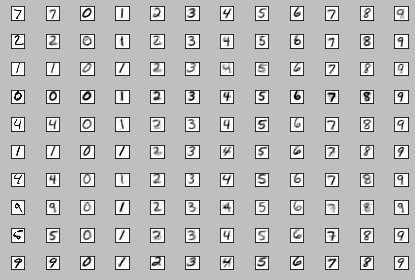

In [14]:
X_test_set = []
Y_test_set = []

for i in range(n_plot_samps):
    tmp_tile_array = np.tile(test_x[i],[10,1])
    X_test_set.append(test_x[i:(i+1),:])
    X_test_set.append(tmp_tile_array)

    Y_test_set.append(test_y[i:(i+1),:])
    #Y_test_set.append(np.array([[0],[1]]))
    Y_test_set.append(np.eye(10))

X_test_set = np.concatenate(X_test_set, axis=0)
Y_test_set = np.concatenate(Y_test_set, axis=0)

X_test_hat = icvae.predict(
 { "x" : X_test_set, "c" : Y_test_set }
)

plot_collection = []
for i in range(n_plot_samps):
    plot_collection.append( test_x[i:(i+1),:] )
    plot_collection.append( X_test_hat[i*11:(i+1)*11,:] )

plot_collection = np.concatenate( plot_collection, axis=0 )

fig = pic.plot_image_grid( \
    1-plot_collection,
    [IMG_DIM, IMG_DIM], \
    (n_plot_samps,12) \
)
plt.show()

Okay, so while it doesn't work amazingly well (...some of those 9s are questionable), it **is** doing two things correctly:
1. Removing the input digit class, e.g. we can't see residual 0 bits when mapping 0 to other digits.
2. Transfering some elements of the style, notably how dark digits are, how tilted each digit is, and their approximate vertical alignment.

With better and more expressive decoders we can improve the reconstruction performance, but the general idea here is clear. Next up: more theory connections to adversaries, and an invariant prediction method.